# Setup

## Imports and Configuration

In [1]:
%load_ext autoreload
%autoreload 2

import scanpy as sc
import os
import re
import json
from datetime import datetime
from anndata import AnnData
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import corescpy as cr

pd.options.display.max_columns = 100
pd.options.display.max_rows = 200
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(20, 20))

palette = "tab20"


def construct_file(sample, slide, date=None, timestamp=None,
                   panel_id="TUQ97N", prefix="output-XETG00189",
                   project_owner="EA", run="CHO-001", directory=None):
    """Construct file path from information."""
    if isinstance(sample, str):
        sample = [sample]
    if "outputs" not in directory and os.path.exists(
            os.path.join(directory, "outputs")):
        directory = os.path.join(directory, "outputs")
    print(directory)
    panel_id, prefix, project_owner, slide, date, timestamp = [
        [x] * len(sample) if isinstance(x, str) else list(x) if x else x
        for x in [panel_id, prefix, project_owner, slide, date, timestamp]]
    run = [run] * len(sample) if isinstance(run, (str, int, float)) else run
    block = ["-".join(i) for i in zip(sample, panel_id, project_owner)]
    fff = [f"{prefix[i]}__{slide[i]}__{block[i]}" for i in range(len(sample))]
    if date is None or timestamp is None:
        for i, x in enumerate(fff):  # iterate current file stems
            ddd = os.path.join(directory, panel_id[i], run[i])
            print(ddd)
            matches = sum([x in d for d in os.listdir(ddd)])
            if  matches != 1:
                raise ValueError(f"{x} found in 0 or multiple file paths",
                                 f"\n\n{os.listdir(ddd)}")
            fff[i] = os.path.join(ddd, np.array(os.listdir(ddd))[np.where([
                x in d for d in os.listdir(ddd)])[0][0]])  # find match
    else:
        fff = [os.path.join(directory, panel_id[i], run[i],
                            f"{x}__{date[i]}__{timestamp[i]}")
               for i, x in enumerate(fff)]
    return fff

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

## Options

In [2]:
# Column Names
col_sample_id_original = "Sample ID"
col_sample_id = "Sample"
col_subject = "Patient"
col_batch = "Slide"
col_path = "file_path"
# col_date_time, col_date = "Date Sectioned", "Date"
col_date_time, col_date = None, None
col_inflamed, col_stricture = "Inflamed", "Stricture"
col_condition = "Condition"
meta_rn = {"Name": col_subject, "Slide ID": col_batch,
           "Inflammation Status": col_inflamed}

# Directories & Metadata
# Replace manually or mirror my file/directory tree in your home
include_stricture = True
run = "CHO-001"
samples = ["50452A", "50452B", "50452C"]
# samples = ["50564A4", "50618B5", "50452A", "50452B", "50452C"]
# run = ["CHO-002"] * 2 + ["CHO-001"] * 3
panel_id = "TUQ97N"
prefix = "output-XETG00189"
project_owner = "EA"
ddu = os.path.expanduser("~")
ddl = "/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library"
ddd = os.path.join(ddl, "outputs", panel_id)
panel = os.path.join(ddu, "projects/senescence/ProposedGenePanel.xlsx")
file_ann = os.path.join(ddu, "corescpy/examples/annotation_guide.xlsx")

# Input/Output Options
reload = False
out_dir = os.path.join(ddd, "nebraska")  # set to None to avoid saving
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Computing Resources
gpu = False
sc.settings.n_jobs = 4
sc.settings.max_memory = 100

# Read Metadata & Other Information
annot_df = pd.read_excel(file_ann)
metadata = pd.read_excel(os.path.join(ddl, "Xenium_Samples_02092024.xlsx"),
                         dtype={"Slide ID": str})
metadata = metadata.rename(meta_rn, axis=1)
if samples not in ["all", None]:  # subset by sample ID?
    metadata = metadata.set_index(col_sample_id_original).loc[
        samples].reset_index()

# Processing & Clustering Options
# resolution = 1.5
# min_dist = 1
# n_comps = 20
resolution = 1.5
min_dist = 0.3
n_comps = 20
# col_qscore = ?
# custom_thresholds = {col_qscore: [, None]}
custom_thresholds = None
genes_subset = list(annot_df.iloc[:, 0])
kws_pp = dict(cell_filter_pmt=None, cell_filter_ncounts=[50, None],
              cell_filter_ngene=[30, None], gene_filter_ncell=[3, None],
              gene_filter_ncounts=[3, None],
              custom_thresholds=custom_thresholds,
              kws_scale=dict(max_value=10, zero_center=True))
kws_umap = dict(min_dist=min_dist, method="rapids") if gpu is True else dict(
    min_dist=min_dist)
kws_cluster = dict(use_gpu=gpu, kws_umap=kws_umap, kws_neighbors=None,
                   use_highly_variable=False, n_comps=n_comps,
                   genes_subset=genes_subset, resolution=resolution)
cell_types = None
genes = ["CDKN1A", "CDKN2A", "TP53", "PLAUR", "PTGER4", "FTL", "IL6ST",
         "CSF2RB", "CSF2RA", "IL7R", "TBX21", "KLRB1", "CCL5", "HSP90AA1",
         "RORC", "IL23R", "KIT", "CCL20", "TCF7", "LTB", "IL22", "IFNG",
         "PDGFRA", "PTPN1", "OSM", "IL13", "IL1B", "IL6", "TNF", "S100A8",
         "S100A9", "NOD2", "LACC1", "LRRK2"]

# Revise Metadata & Construct Variables from Options
if col_stricture not in metadata.columns:
    metadata.loc[:, col_stricture] = metadata["Sample Location"].apply(
        lambda x: "Stricture" if "stricture" in x.lower() else "None")
metadata.loc[:, col_condition] = metadata.apply(
    lambda x: "Stricture" if "stricture" in x[col_stricture].lower() else x[
        col_inflamed].capitalize() , axis=1)
if col_date_time:
    metadata.loc[:, col_date] = metadata[col_date_time].apply(
        lambda x: datetime.strftime(x, "%Y%m%d"))
    dates = list(metadata[col_date])
else:
    dates = None
metadata.loc[:, col_sample_id] = metadata.apply(
    lambda x: f"{x[col_condition]}-{x[col_sample_id_original]}" , axis=1)
metadata = metadata.set_index(col_sample_id)
metadata.loc[:, col_path] = construct_file(
    list(metadata[col_sample_id_original]), list(metadata[col_batch]),
    dates, panel_id=panel_id, prefix=prefix,
    project_owner=project_owner, run=run, directory=ddl)
col_cell_type = "Annotation"
file_path_dict = dict(zip(metadata.index.values, metadata["file_path"]))
kws_init = dict(col_batch=col_batch, col_subject=col_subject,
                col_sample_id=col_sample_id, col_cell_type=col_cell_type)

# Output Files
suff = str(f"res{re.sub('[.]', 'pt', str(resolution))}_dist"
           f"{re.sub('[.]', 'pt', str(min_dist))}_npc{n_comps}")  # file end
out_files = []
for x in metadata.index.values:
    if out_dir is not None:
        out_files += [os.path.join(out_dir, f"{x}__{suff}.zarr")]

# Subset if Desired
if include_stricture is False:
    metadata = metadata[metadata.Stricture != "Stricture"]
metadata

# Genes
# genes = ["CDKN1A", "CDKN2A", "TP53", "PLAUR", "PTGER4", "FTL", "IL6ST"]
# cell_types = ["ILC3", "LTi-like NCR+ ILC3", "LTi-like NCR- ILC3",
#               "ILCP", "Macrophages", "Stem cells"]
# palette = ["r", "tab:pink", "m", "b", "tab:brown", "cyan"]
# High in inf. vs. un
# OSM
# IL13
# IL1B
# IL6
# TNF
# S100A8
# S100A9
# ------------------------------
# High in stricture vs inf/un
# PDGFRA
# IL6ST
# PTPN1
# IFNG

/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs
/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/CHO-001
/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/CHO-001
/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/CHO-001


,Sample ID,Patient,Status,Project,Sample Location,Inflamed,Slide,GRID ID,Procedure Date,Age,Sex,Race,Hispanic,Diagnosis,Project.1,Procedure,Disease Status,Date Collected,Date Sectioned,Date of Hybridization,Storage in 4C,Created By,Created,Storage Status,Sample Location.1,Storage Row,Storage Col,Checked Out By,Stricture,Condition,file_path
Sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Uninflamed-50452A,50452A,50452,Available,scRNA & Spatial,Terminal Ileum,uninflamed,0010700,1011335,2023-12-04,69,female,white,NO,Crohn's Disease,Helmsley-Senescence,Resection,Active,NaN,2024-01-22 15:25:38,2024-01-23 15:25:58,YES,ksenija sabic,2024-02-06 15:26:47.887,Not in storage,NaN,NaN,NaN,NaN,None,Uninflamed,/mnt/cho_lab/disk2/elizabeth/data/shared-xeniu...
Inflamed-50452B,50452B,50452,Available,scRNA & Spatial,Terminal Ileum,inflamed,0010700,1011335,2023-12-04,69,female,white,NO,Crohn's Disease,Helmsley-Senescence,Resection,Active,NaN,2024-01-22 00:00:00,2024-01-23 00:00:00,YES,ksenija sabic,2024-02-06 15:26:47.887,Not in storage,NaN,NaN,NaN,NaN,None,Inflamed,/mnt/cho_lab/disk2/elizabeth/data/shared-xeniu...
Stricture-50452C,50452C,50452,Available,scRNA & Spatial,Terminal Ileum (stricture),inflamed,0010663,1011335,2023-12-04,69,female,white,NO,Crohn's Disease,Helmsley-Senescence,Resection,Active,NaN,2024-01-22 00:00:00,2024-01-23 00:00:00,YES,ksenija sabic,2024-02-06 15:26:47.887,Not in storage,NaN,NaN,NaN,NaN,Stricture,Stricture,/mnt/cho_lab/disk2/elizabeth/data/shared-xeniu...


## Re-Name Files in Standard Form Using Object

In [ ]:
# fff = list(pd.Series([x if "h5ad" in x else np.nan for x in os.listdir(
#     out_dir)]).dropna())
# frn = []
# for x in fff:
#     ann = sc.read(os.path.join(out_dir, x))
#     kwu = re.sub("{", "", re.sub("}", "", str(ann.obs.iloc[0].kws_umap))
#                  ).split(", ")
#     kwu = np.array(kwu)[np.where(["min_dist" in x for x in kwu])[
#         0]][0].split(": ")[1]
#     frn += [str(f"{str(ann.obs.iloc[0][col_sample_id])}__"
#                 f"res{str(ann.obs.iloc[0].resolution)}"
#                 f"_dist{kwu}_npc{ann.varm['PCs'].shape[1]}")]
# frd = dict(zip([os.path.join(out_dir, i) for i in fff], [os.path.join(
#     out_dir, re.sub("[.]", "pt", re.sub("[.]h5ad", "", i)) + ".h5ad")
#                                                          for i in frn]))
# frd
# # for x in frd:
# #     os.system(f"mv {x} {frd[x]}")

# Data

## Loading

In [3]:
%%time

# metadata = dict(zip(["Uninflamed-50452A", "Inflamed-50452B"], [
#     metadata[x] for x in ["Uninflamed-50452A", "Inflamed-50452B"]]))
suff = str(f"res{re.sub('[.]', 'pt', str(resolution))}_dist"
           f"{re.sub('[.]', 'pt', str(min_dist))}_npc{n_comps}")  # file end
selves = []
for x in metadata.index.values:
    self = cr.Spatial(metadata.loc[x][col_path], library_id=x, **kws_init)
    for i in metadata:  # add metadata for subject
        self.rna.obs.loc[:, i] = str(metadata.loc[x][i])  # add metadata
    selves += [self]
        # out_files += [os.path.join(out_dir, f"{x}.zarr")]
# # self.print_tiff()  # print tiff info



<<< INITIALIZING SPATIAL CLASS OBJECT >>>



<<< INITIALIZING OMICS CLASS OBJECT >>>

Unused keyword arguments: {'library_id': 'Uninflamed-50452A', 'visium': False}.




col_gene_symbols="gene_symbols"
col_cell_type="Annotation"
col_sample_id="Sample"
col_batch="Slide"
col_subject="Patient"
col_condition=None
col_num_umis=None



key_control=None
key_treatment=None
INFO     reading                                                                                                   
         /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/CHO-001/output-XETG00189__0010700__
         50452A-TUQ97N-EA__20240126__205019/cell_feature_matrix.h5                                                 


dsfasfda AnnData object with n_obs × n_vars = 333825 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial', 'original_ix'
    obsm: 'spatial'


Cell Counts: Initial


Observations: 333825



Gene Counts: Initial

Empty DataFrame
Columns: [index, gene_ids, feature_types, genome]
Index: []





 SpatialData object with:
├── Images
│     ├── 'morphology_focus': MultiscaleSpatialImage[cyx] (1, 57808, 45580), (1, 28904, 22790), (1, 14452, 11395), (1, 7226, 5697), (1, 3613, 2848)
│     └── 'morphology_mip': MultiscaleSpatialImage[cyx] (1, 57808, 45580), (1, 28904, 22790), (1, 14452, 11395), (1, 7226, 5697), (1, 3613, 2848)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 10) (3D points)
├── Shapes
│     ├── 'cell_boundar

## Check Genes

In [ ]:
for s in selves:
    _ = s.read_panel(directory=os.path.join(
        ddd, metadata.loc[s._library_id]["file_path"]))

## Explore

In [ ]:
[s.print() for s in selves]
# kim = f"{self._library_id}{cr.pp.SPATIAL_IMAGE_KEY_SEP}morphology_mip"
# s.adata.pl.render_images(kim)
# print(dir(s.adata.images[kim]))
# s.adata.shapes["nucleus_boundaries"]

## All Data QC

In [ ]:
hue = selves[0]._columns["col_sample_id"]
ids = [str(s.rna.obs[hue].iloc[0]) for s in selves]
patterns = [("MT-", "mt-"), ("RPS", "RPL", "rps", "rpl"), (
    "^HB[^(P)]", "^hb[^(p)]")]  # pattern matching for gene symbols
patterns = dict(zip(["mt", "ribo", "hb"], patterns))  # dictionary
names = dict(zip(["mt", "ribo", "hb"],
                    ["Mitochondrial", "Ribosomal", "Hemoglobin"]))
p_names = [names[k] if k in names else k for k in patterns]  # "pretty"
patterns_names = dict(zip(patterns, p_names))  # map abbreviated to pretty
adata = AnnData.concatenate(
    *[x.rna for x in selves], join="outer", batch_key=hue,
    batch_categories=ids, index_unique=None, uns_merge="unique")
qc_vars = []  # to hold mt, rb, hb, etc. if present in data
for k in patterns:  # calculate MT, RB, HB counts
    gvars = adata.var_names.str.startswith(patterns[k])
    if any(gvars):
        qc_vars += [k]
    adata.var[k] = gvars
pct_n = [f"pct_counts_{k}" for k in qc_vars]  # "% counts" variables
cgs = selves[0]._columns["col_gene_symbols"] if selves[
    0].rna.var.index.values[0] not in selves[0].rna.var_names else None
adata.obs = adata.obs.astype({col_condition: "category"})
ggg = list(set(genes).intersection(adata.var_names))
ctm = list(set(["n_genes_by_counts", "total_counts", "log1p_total_counts",
                "cell_area", "nucleus_area"]
               ).intersection(adata.obs.columns))
vam = pct_n + ctm + [hue]  # QC variable names
mets_df = adata.obs[vam].rename_axis("Metric", axis=1).rename(
    {"total_counts": "Total Counts in Cell", "cell_area": "Cell Area",
     "nucleus_area": "Nucleus Area",
     "n_genes_by_counts": "Genes Detected in Cell",
     "log1p_total_counts": "Log-Normalized Total Counts",
     **patterns_names}, axis=1)  # rename
fff = sb.pairplot(
    mets_df, hue=hue, height=3, diag_kind="hist",
    plot_kws=dict(marker=".", linewidth=0.05))  # pair

## Update from Saved h5ad?

In [ ]:
if reload is True:
    for i, s in enumerate(selves):
        s.update_from_h5ad(file=out_files[i])

# Whole Process Example

## Nebraska

In [ ]:
# self = selves[0]
# _ = self.preprocess(**kws_pp)
# _ = self.cluster(**kws_cluster)
# # self.adata.write(out_files[i], overwrite=True)  # optional, write object
# self.calculate_centrality(n_jobs=4)
# self.find_cooccurrence(figsize=(60, 20), kws_plot=dict(wspace=3))
# self.find_svgs(genes=genes, method="moran", n_perms=10, kws_plot=dict(
#     legend_fontsize="large"), figsize=(15, 15))
# self.calculate_receptor_ligand(col_condition=False, p_threshold=0.001,
#                                remove_ns=True, figsize=(20, 20))

## Bare Squidpy

In [ ]:
# import squidpy as sq
# import scanpy as sc
# import spatialdata_io as sdio

# col_cell_type = "leiden"
# n_jobs = 4
# file = file_path_dict[list(file_path_dict.keys())[0]]

# sdata = sdio.xenium(file, n_jobs=n_jobs)

# sq.gr.spatial_neighbors(sdata.table)
# sc.pp.pca(sdata.table)
# sc.pp.neighbors(sdata.table)
# sc.tl.leiden(sdata.table)
# sq.gr.nhood_enrichment(sdata, cluster_key=col_cell_type, seed=1618)
# sq.gr.co_occurrence(sdata, cluster_key=col_cell_type, n_jobs=n_jobs)
# sq.pl.spatial_scatter(sdata, color=col_cell_type, shape="hex")
# cr.pl.plot_cooccurrence(sdata, col_cell_type=col_cell_type)
# sq.gr.spatial_autocorr(sdata, mode="moran", n_jobs=n_jobs)
# sq.pl.spatial_scatter(adata, color=genes + [col_cell_type], shape="hex")
# sdata[0].images["morphology_mip"]

# Processing

## Preprocessing

{'cell_filter_pmt': None, 'cell_filter_ncounts': [50, None], 'cell_filter_ngene': [30, None], 'gene_filter_ncell': [3, None], 'gene_filter_ncounts': [3, None], 'custom_thresholds': None, 'kws_scale': {'max_value': 10, 'zero_center': True}}


[autoreload of corescpy.class_sc failed: Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/miniconda3/envs/py-bio/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/elizabeth/elizabeth/miniconda3/envs/py-bio/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/home/elizabeth/elizabeth/miniconda3/envs/py-bio/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/elizabeth/elizabeth/corescpy/corescpy/c


Un-Used Keyword Arguments: {'assay_protein': None, 'col_condition': None, 'col_num_umis': None, 'col_segment': 'region'}




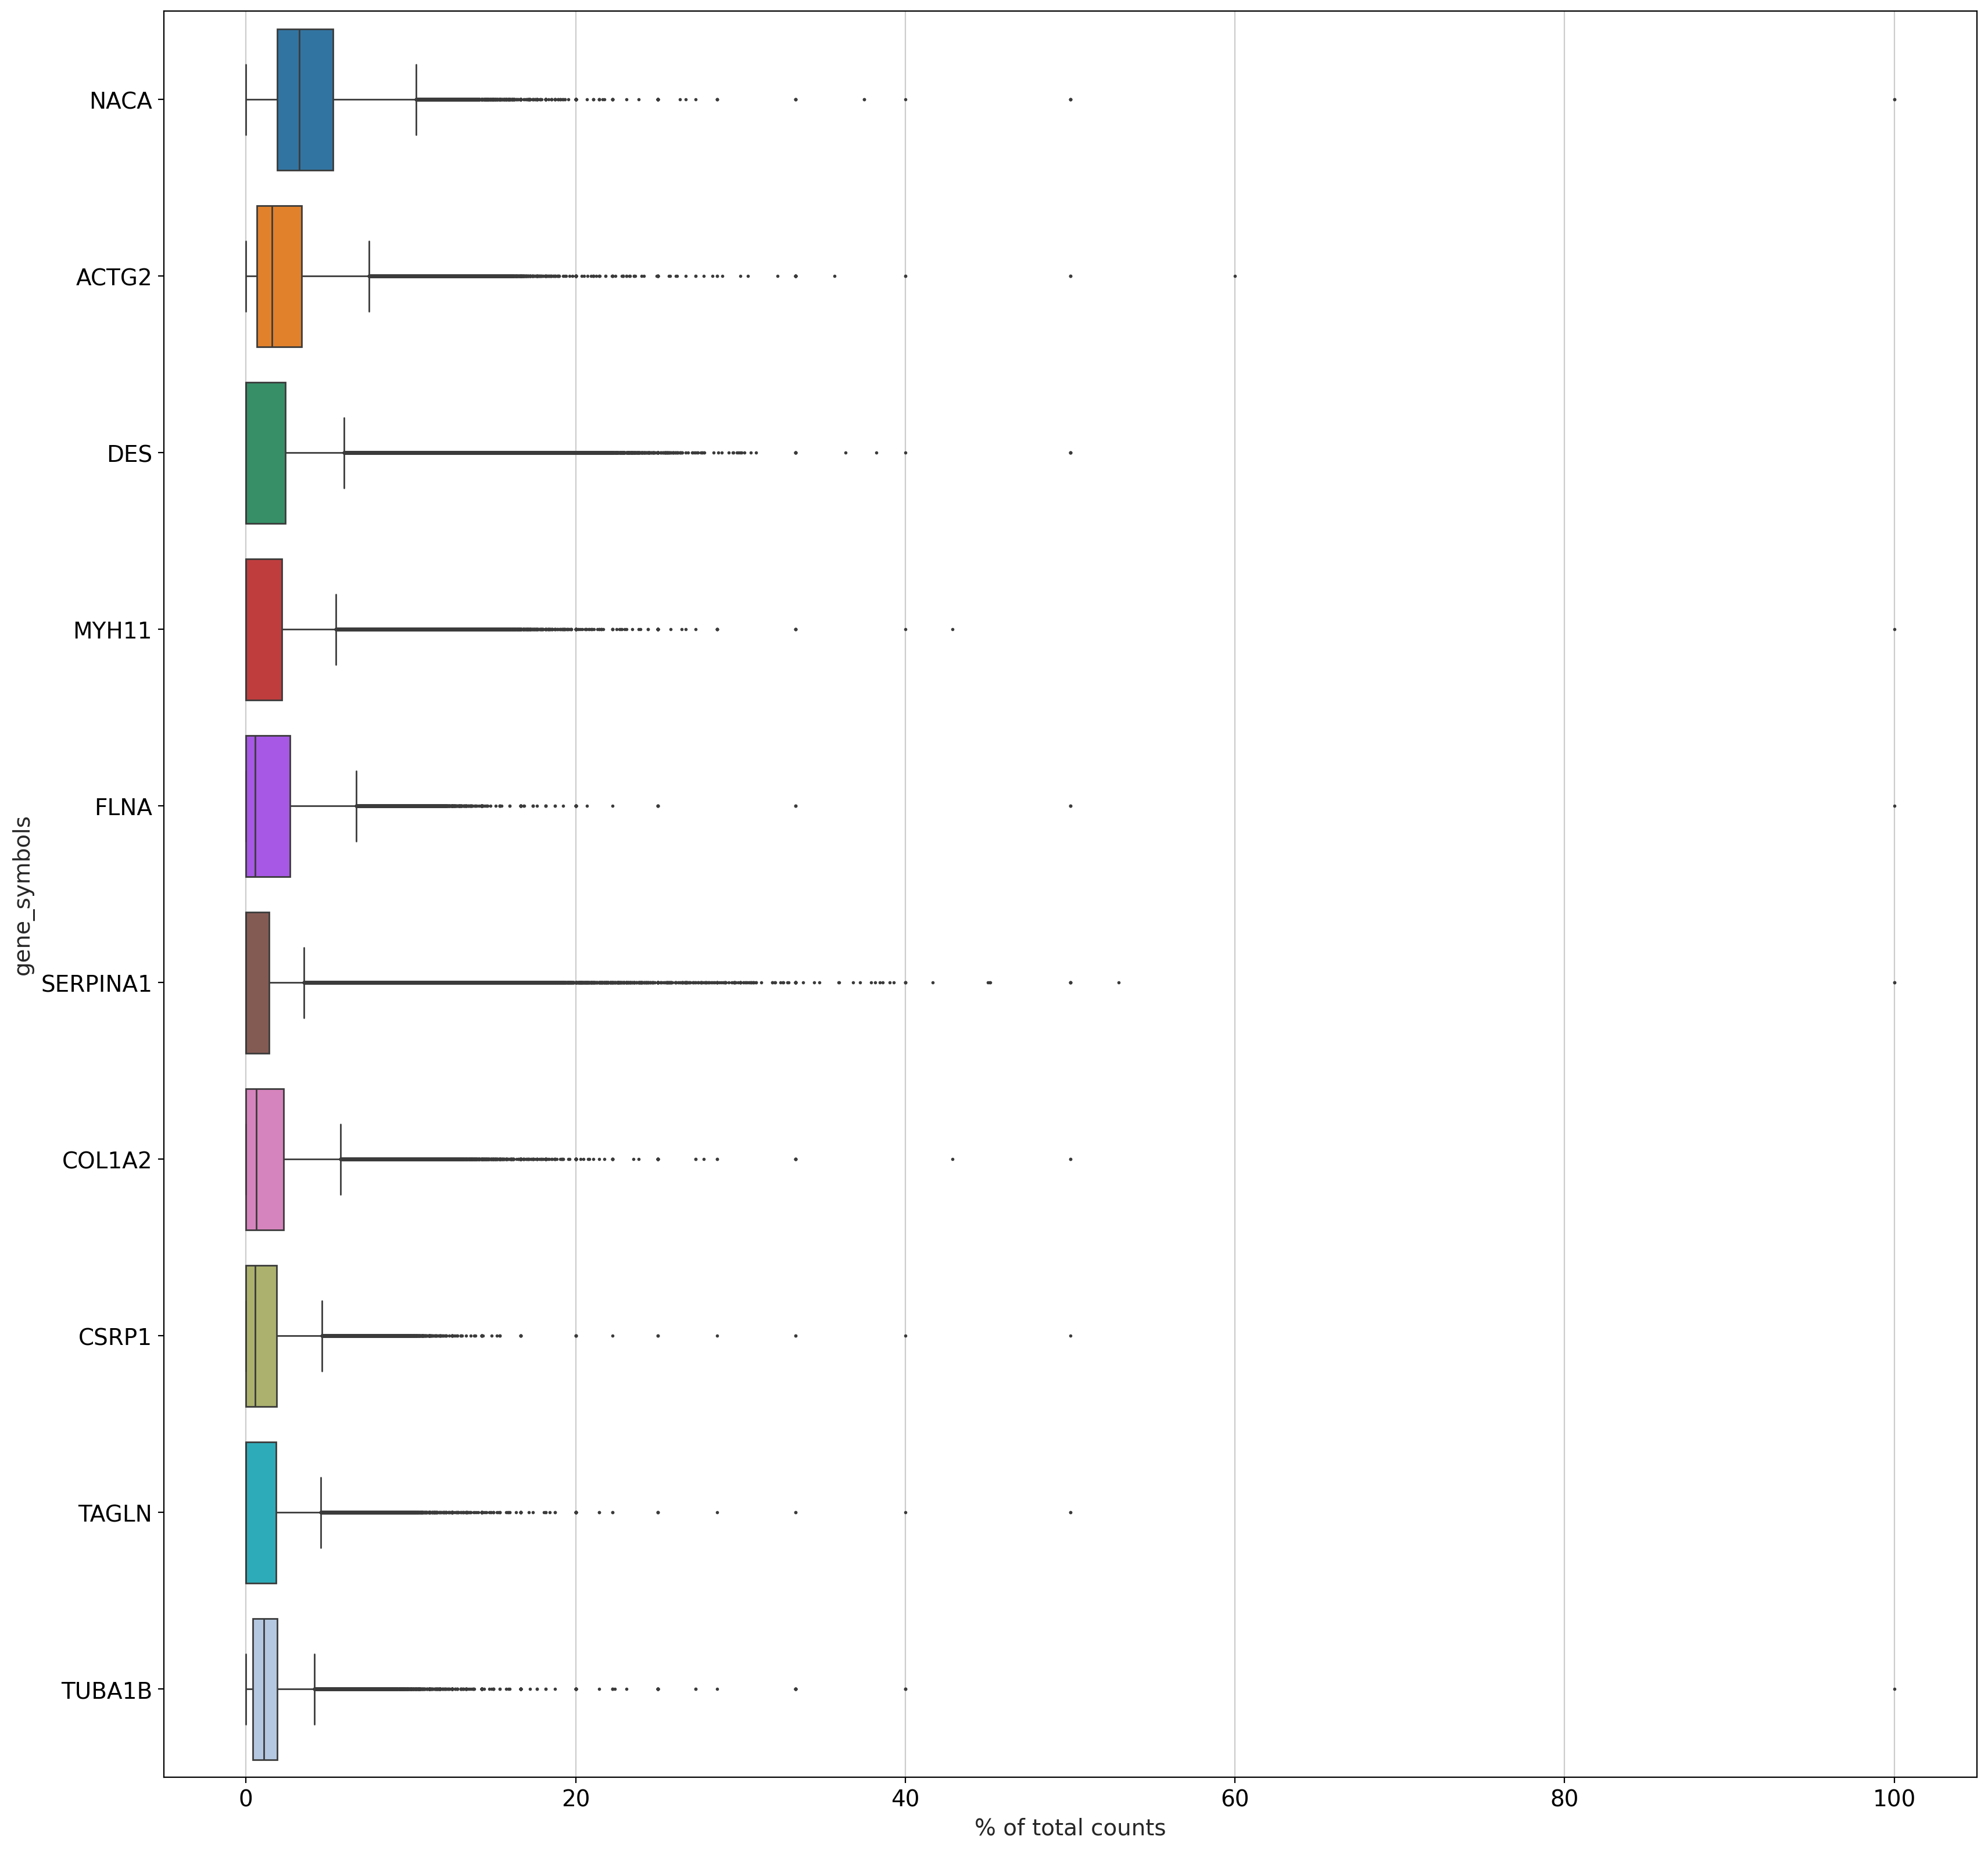

dsfasfda AnnData object with n_obs × n_vars = 333825 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Sample Location', 'Inflamed', 'Slide', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease Status', 'Date Collected', 'Date Sectioned', 'Date of Hybridization', 'Storage in 4C', 'Created By', 'Created', 'Storage Status', 'Sample Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Stricture', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial', 'original_ix'
    obsm: 'spatial'
    layers: 'counts'


Cell Counts: Initial


Observations: 333825



Gene Counts: Initial

Empty DataFrame
Columns: [gene_symbols, 

... storing 'Sample' as categorical
... storing 'Sample ID' as categorical
... storing 'Patient' as categorical
... storing 'Status' as categorical
... storing 'Project' as categorical
... storing 'Sample Location' as categorical
... storing 'Inflamed' as categorical
... storing 'Slide' as categorical
... storing 'GRID ID' as categorical
... storing 'Procedure Date' as categorical
... storing 'Age' as categorical
... storing 'Sex' as categorical
... storing 'Race' as categorical
... storing 'Hispanic' as categorical
... storing 'Diagnosis' as categorical
... storing 'Project.1' as categorical
... storing 'Procedure' as categorical
... storing 'Disease Status' as categorical
... storing 'Date Collected' as categorical
... storing 'Date Sectioned' as categorical
... storing 'Date of Hybridization' as categorical
... storing 'Storage in 4C' as categorical
... storing 'Created By' as categorical
... storing 'Created' as categorical
... storing 'Storage Status' as categorical
... storing 'S

Sample nucleus_area
Sample cell_area


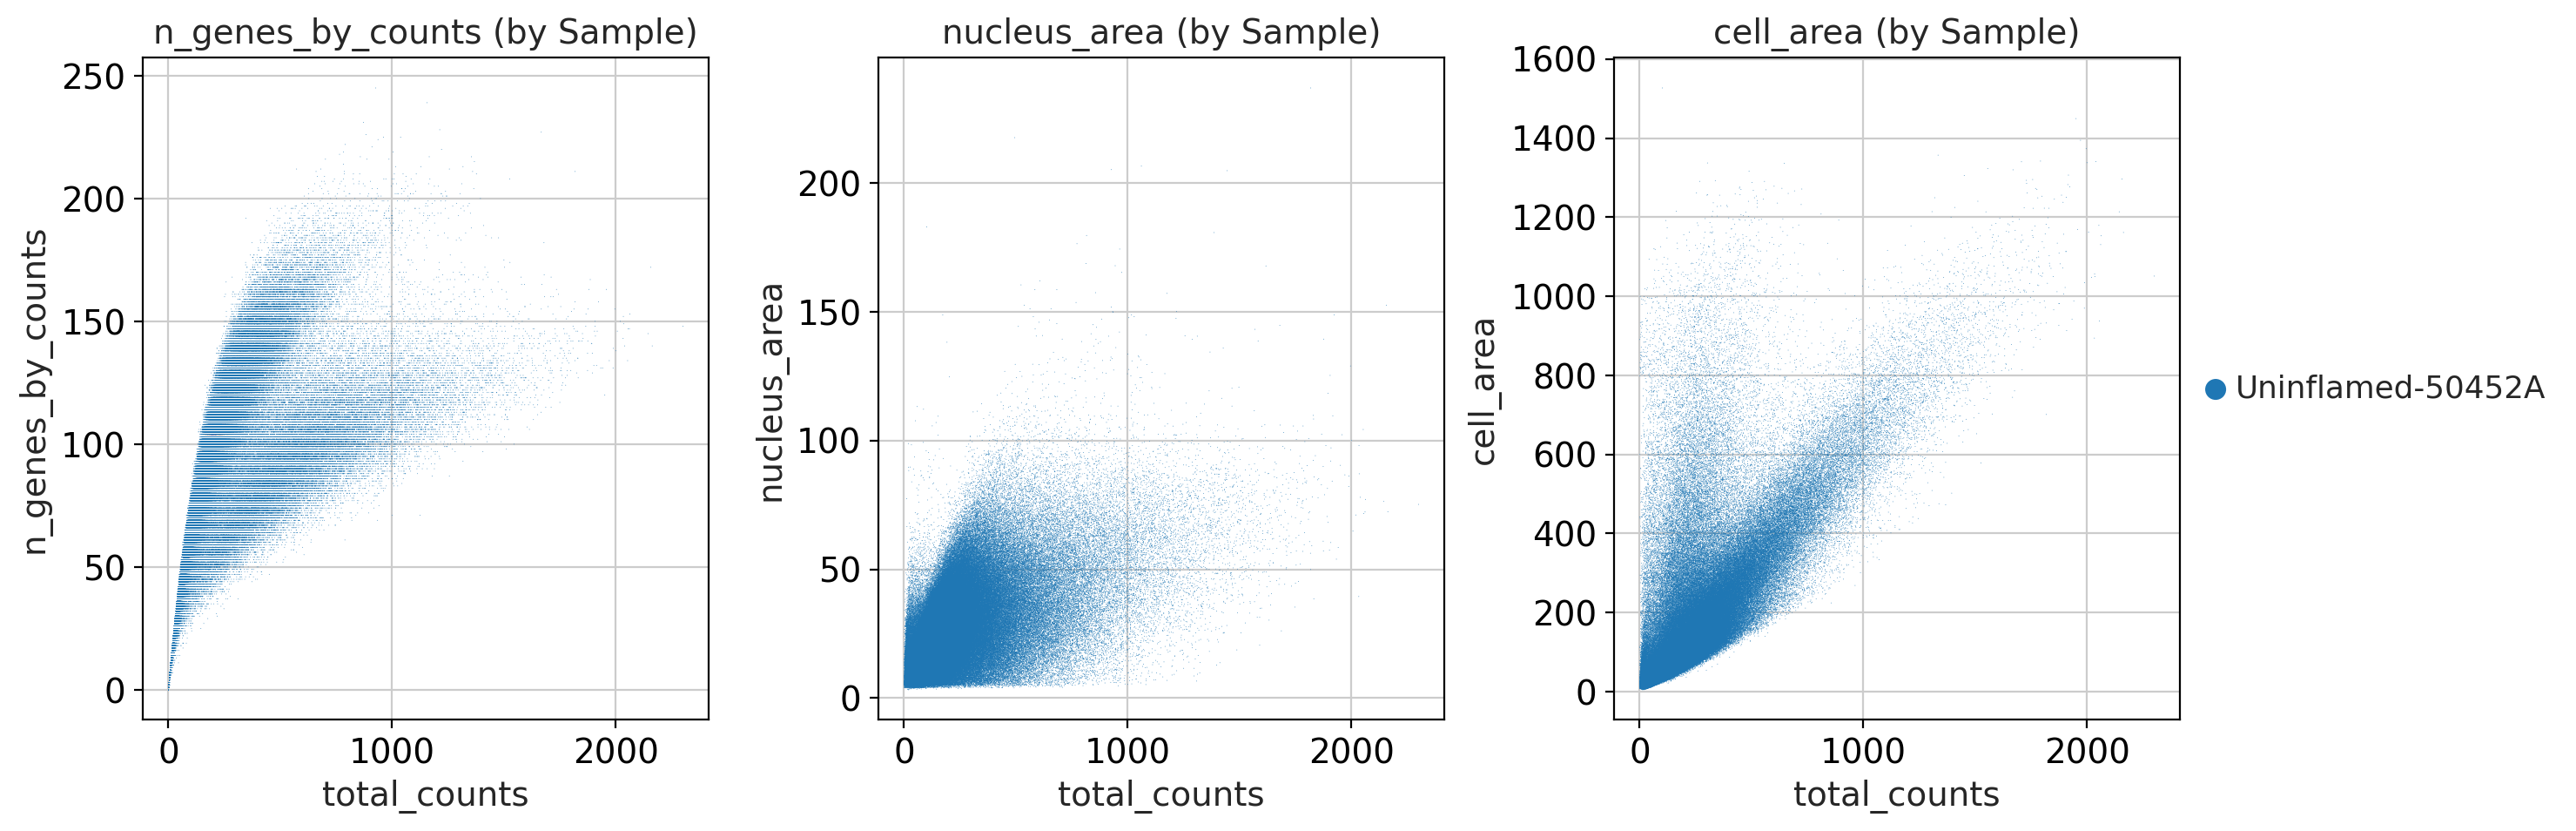

In [4]:
%%time

# Perform Pre-Processing
if reload is False:
    print(kws_pp)
    for s in selves:
        _ = s.preprocess(**kws_pp, figsize=(20, 20))

# Check Remaining Genes
for s in selves:
    _ = s.read_panel(directory=os.path.join(
        ddd, metadata.loc[s._library_id]["file_path"]))

## Clustering

In [ ]:
%%time

# Cluster & Write Objects
if reload is False:
    for i, s in enumerate(selves):
        _ = s.cluster(**kws_cluster)  # cluster
        _ = s.find_markers(n_genes=5, out_file=os.path.splitext(
            out_files[i])[0] + "_markers.csv")  # find cluster gene markers
        _ = s.annotate_clusters(file_ann, col_annotation=col_cell_type)
        if out_files is not None and len(out_files) > 0:
            s.write(out_files[i])  # write adata.table to h5ad
        _ = s.plot_spatial(title=s._library_id, color=col_cell_type)  # plot

## Annotations

In [ ]:
%%time

# Manual Annotations
# annots = {
#     0: {"0": "Myofibroblast", "1": "Goblet", "2": "Cycling B",
#         "3": "Fibroblast", "4": "Endothelial",
#         # "5": "Goblet",
#         "5": "Epithelial",
#         # "6": "Goblet (Best, 2+?)", "7": "Myeloid (Macrophage? DC?)",
#         "6": "Epithelial", "7": "Myeloid",
#         "8": "Mesenchymal-Fibrolastic-Stromal 3",
#         "9": "Plasma", "10": "T Cell", "11": "Macrophage, LYVE1+",
#         "12": "Pericyte", "13": "Endothelial Lymphatic",
#         "14": "Mast", "15": "Mesenchymal-Myocytic-Myofibroblast"},
#     1: {"0": "Contractile Pericyte",
#         "1": "Mesenchymal-Fibroblastic-Stromal 1,3",
#         "2": "Endothelial", "3": "B Cell", "4": "T Cell",
#         "5": "Mesenchymal-Fibroblastic-Stromal 1", "6": "Myofibroblast",
#         "7": "Epithelial", "8": "Plasma", "9": "Macrophage",
#         "10": "Myeloid", "11": "Mast",
#         "12": "Lymphatic Endothelial", "13": "Neural"},
#     2: {"0": "B Cell", "1": "Mesenchymal", "2": "T/NK Cell",
#         "3": "Mesenchymal-Fibroblastic-Transitional Stromal 1",
#         "4": "Smooth Muscle", "5": "Endothelial", "6": "Macrophage",
#         "7": "Lymphatic Endothelial",
#         "8": "Smooth Muscle/Pericyte/Myofibroblast?",
#         "9": "IgA Plasma", "10": "Cycling B Cell",
#         "11": "Epithelial-Enterocyte-Tuft?", "12": "Neural"}
# }

# ONLY FOR RESOLUTION = 0.75,
# JUST CELL TYPE GENES USED IN CLUSTERING,
# MIN_DIST = 0.80
# rename_annotations = {
#     str("Activated CD4 T_Branch A4 (IN)_CLP_Colonocyte_Contractile Pericyte"
#         " (PLN+)_D Cells (SST+)_FCRL4+ Memory B_FDC_Fetal Arterial EC_Glia"
#         " 2 (ELN+)_ILCP_Lymphoid DC_Macrophages_Mast Cell_Microfold Cell_N"
#         " Cells (NTS+)_NK Cell_Pericyte_SELL+ CD8 T_Stromal 1 (ADAMDEC1+)"
#         "_TRGV2 Gdt_cDC2"): "Mixed Immune",
#     str("Activated CD4 T_BEST2+ Goblet Cell_Branch A4 (IN)_CLP_Colonocyte_"
#         "Contractile Pericyte (PLN+)_D Cells (SST+)_FCRL4+ Memory B_FDC"
#         "_Fetal Arterial EC_Glia 2 (ELN+)_ILCP_Immature B_Macrophages"
#         "_Microfold Cell_NK Cell_Pericyte_SELL+ CD8 T_Stromal 1 (ADAMDEC1+)"
#         "_TRGV2 Gdt_cDC2_mLTo"): "Immune (Lymphoid?)",
#     str("Activated CD4 T_Branch A4 (IN)_CLP_Colonocyte_Contractile Pericyte"
#         " (PLN+)_D Cells (SST+)_FCRL4+ Memory B_FDC_Fetal Arterial EC_Glia"
#         " 2 (ELN+)_ILCP_Lymphoid DC_Macrophages_Mast Cell_Microfold Cell_N"
#         " Cells (NTS+)_NK Cell_Pericyte_SELL+ CD8 T_Stromal 1 (ADAMDEC1+)_"
#         "TRGV2 Gdt_cDC2"): "Mixed Immune",
#     str("Activated CD4 T_Branch A4 (IN)_CD8 Tmem_CLP_FCRL4+ Memory B_FDC_"
#         "Fetal Arterial EC_Glia 2 (ELN+)_ILCP_Lti-like NCR+ ILC3_Lymphoid"
#         " DC_Macrophages_Mast Cell_Megakaryocyte_Microfold Cell_NK Cell_"
#         "Pericyte_SELL+ CD8 T_TRGV2 Gdt_mLTo"): "Mixed Immune",
#     str("Activated CD4 T_Branch A4 (IN)_CLP_Distal Progenitor_FCRL4+ Memory"
#         " B_FDC_Fetal Arterial EC_Glia 2 (ELN+)_ILC3_Lti-like NCR+ ILC3_"
#         "Macrophages_Mast Cell_Microfold Cell_Monocytes_Pericyte_Proximal "
#         "Progenitor_SELL+ CD8 T_Stromal 1 (ADAMDEC1+)_"
#         "TRGV2 Gdt"): "B_T_ILC",
#     str("Angiogenic Pericyte_Immature Pericyte_LYVE1+ Macrophage"
#         ): "Pericyte_Macrophage"}

rename_annotations = None

# Rename Annotations
if rename_annotations is not None:
    for i, s in enumerate(selves):
        # s.rna.obs.loc[:, "Annotation_EA"] = s.rna.obs[
        #     "leiden"].replace(annots[i])
        s.rna.obs.loc[:, "Annotation_Auto"] = s.rna.obs["Annotation"].copy()
        s.rna.obs.loc[:, "Annotation"] = s.rna.obs["Annotation"].replace(
            rename_annotations if isinstance(
                rename_annotations, dict) else rename_annotations[i])
    [print(list(s.rna.obs["Annotation"].unique())) for s in selves]
    for s in selves:
        s.plot_spatial(title=s._library_id)

## Concatenate AnnData

In [ ]:
hue = selves[0]._columns["col_sample_id"]
ids = [str(s.rna.obs[hue].iloc[0]) for s in selves]
adata = AnnData.concatenate(
    *[x.rna for x in selves], join="outer", batch_key=hue,
    batch_categories=ids, index_unique=None, uns_merge="unique")

## Preliminary Exploration

In [ ]:
# for s in selves:
#     _ = s.read_panel(directory=metadata[s._library_id]["file_path"])
# for s in selves:
#     s.plot_umap(color=genes + [self._columns["col_cell_type"]],
#                 layer="scaled", cmap="coolwarm", vcenter=0)
cct = selves[0]._columns["col_cell_type"]
for g in [["CDKN1A", "CDKN2A", "TP53", "PLAUR", "PTGER4", "FTL", "IL6ST"],
          ["CSF2RB", "CSF2RA", "IL7R", "TBX21", "KLRB1", "CCL5", "HSP90AA1",
           "RORC", "IL23R", "KIT", "CCL20", "TCF7", "LTB", "IL22", "IFNG"],
          ["PDGFRA", "IL6ST", "PTPN1", "IFNG"]]:
    ggg = list(set(g).intersection(adata.var_names))
    cr.pl.plot_cat_split(adata, col_inflamed, col_cell_type=cct,
                         genes=ggg, kind="box")
    cr.pl.plot_cat_split(adata, col_inflamed, col_cell_type=cct,
                         genes=ggg, columns=col_stricture, kind="box")

# Analyses

## Centrality Scores

In [ ]:
%%time

for s in selves:
    s.calculate_centrality(n_jobs=sc.settings.n_jobs)

## Cell Type Co-Occurrence

In [ ]:
%%time

for s in selves:
    _ = s.find_cooccurrence(figsize=(60, 20), kws_plot=dict(wspace=3))

## Neighborhood Enrichment Analysis

In [ ]:
%%time

for s in selves:
    _ = s.calculate_neighborhood(figsize=(60, 30))

## Spatial Clustering

In [ ]:
for s in selves:
    _ = s.cluster_spatial()

## Spatially-Variable Genes

In [ ]:
%%time

kws = dict(kws_plot=dict(legend_fontsize="large"), figsize=(15, 15))
for s in selves:
    _ = s.find_svgs(genes=genes, method="moran", n_perms=10, **kws)

## Receptor-Ligand Interactions

In [ ]:
%%time

for s in selves:
    # kss, ktt = [s.rna.obs[s._columns["col_cell_type"]].unique(
    #     ).to_list()[i:(4 + i)] for i in [1, 2]]
    kss, ktt = None, None
    _ = s.calculate_receptor_ligand(
        col_condition=False, p_threshold=0.01, remove_ns=True,
        figsize=(30, 10), top_n=25, key_sources=kss, key_targets=ktt)

In [ ]:
for s in selves:
    s.calculate_receptor_ligand_spatial()

## Cell Type Composition 

In [ ]:
for s in selves:
    s.run_composition_analysis()

## Compare GEX

In [ ]:
# goi = ["CSF2", "CSF2RB", "CSF2RA", "CDKN1A", "CDKN2A", "TP53", "PLAUR"]
# goi = ["CDKN1A", "CDKN2A", "TP53", "PLAUR", "PTGER4", "FTL", "IL6ST", "CSF2",
#        "CSF2RB", "CSF2RA", "IL7R", "TBX21", "KLRB1", "CCL5", "HSP90AA1",
#        "RORC", "IL23R", "KIT", "CCL20", "TCF7", "LTB", "IL22", "IFNG"]
# goi = genes

# fig, axs = selves[0].plot_compare_spatial(selves[1:], goi)

# fig, axs = plt.subplots(len(goi) + 1, len(selves),
#                         figsize=(5 * len(goi), 20 * len(selves)))
# for j, s in enumerate(selves):
#     for i, g in enumerate(goi + [s._columns["col_cell_type"]]):
#         s.plot_spatial(ax=axs[i, j], color=None if i == 0 else goi[i - 1],
#                        cmap="magma", layer=s._layers["log1p"])
#         if i == 0:
#             axs[i, j].set_title(s._library_id)
# plt.subplots_adjust(wspace=0.3)
# fig.show()


### Senescence

In [ ]:
goi = ["CDKN1A", "CDKN2A", "TP53", "PLAUR", "PTGER4", "FTL", "IL6ST"]
fig, axs = selves[0].plot_compare_spatial(selves[1:], goi)

### CSF2RB

In [ ]:
%%time

goi = ["CSF2RB", "CSF2RA", "IL7R", "TBX21", "KLRB1", "CCL5", "HSP90AA1",
       "RORC", "IL23R", "KIT", "CCL20", "TCF7", "LTB", "IL22", "IFNG"]
fig, axs = selves[0].plot_compare_spatial(selves[1:], goi, figsize=(40, 70))

### High in Inflamed vs. Un-Inflamed? 

In [ ]:
%%time
goi = ["OSM", "IL13", "IL1B", "IL6", "TNF", "S100A8", "S100A9"]
fig, axs = selves[0].plot_compare_spatial(selves[1:], goi)

### High in Stricture vs. Uni-Inflamed?

In [ ]:
%%time

goi = ["PDGFRA", "IL6ST", "PTPN1", "IFNG"]
fig, axs = selves[0].plot_compare_spatial(selves[1:], goi)

# Workspace (IGNORE)

## Calculate QC Metrics

In [ ]:
# QC Variables
patterns = [("MT-", "mt-"), ("RPS", "RPL", "rps", "rpl"), (
    "^HB[^(P)]", "^hb[^(p)]")]  # pattern matching for gene symbols
patterns = dict(zip(["mt", "ribo", "hb"], patterns))  # dictionary
names = dict(zip(["mt", "ribo", "hb"],
                ["Mitochondrial", "Ribosomal", "Hemoglobin"]))
p_names = [names[k] if k in names else k for k in patterns]  # "pretty"
patterns_names = dict(zip(patterns, p_names))  # map abbreviated to pretty
rename_perc = dict(zip([f"pct_counts_{p}" for p in names], [
    names[p] + " " + "%" + " of Counts" for p in names]))

# Calculate QC Metrics
for s in selves:
    s.get_layer(layer=s._layers["counts"], inplace=True)
    for k in patterns:
        gvars = s.rna.var_names.str.startswith(patterns[k])
        if any(gvars):
            s.rna.var[k] = gvars
            qc_vars += [k]
    sc.pp.calculate_qc_metrics(
        s.rna, percent_top=None, inplace=True, log1p=True)
[x.rna for x in selves]

In [ ]:
hue = selves[0]._columns["col_sample_id"]
ids = [str(s.rna.obs[hue].iloc[0]) for s in selves]
adata = AnnData.concatenate(
    *[x.rna for x in selves], join="outer", batch_key=hue,
    batch_categories=ids, index_unique=None, uns_merge="unique")

In [ ]:
vam = pct_n + ["n_genes_by_counts", "total_counts"] + list(
    [h] if h else [])  # QC variable names
rnd = {"total_counts": "Total Counts in Cell", **rename_perc,
        "n_genes_by_counts": "Genes Detected in Cell", **patterns_names}
mets_df = adata.obs[vam].rename_axis("Metric", axis=1).rename(rnd, axis=1)
fff = seaborn.pairplot(
    mets_df, diag_kind="kde", hue=hue,
    diag_kws=dict(fill=True, cut=0), plot_kws=dict(
        marker=".", linewidth=0.05), height=5)  # QC pairplot

In [ ]:
if any(("pct_dropout_by_counts" in c for c in adata.var.columns)):
    ids = list(adata.obs[h].unique()) if h else None
    var_do = "Percent Dropout by Counts"
    if ids is not None:
        dropout = [f"pct_dropout_by_counts-{i}" for i in ids]
        dff = pd.concat([adata.var[d].to_frame(var_do)
                        for d in dropout], keys=ids, names=["Sample", "Gene"])
    else:
        dff = adata.var[d].to_frame(var_do)
    seaborn.catplot(dff, x=var_do, hue="Gene", col=h,
                    col_order=ids, kind="swarm", legend=False)

In [ ]:
pct_n = []
ctm = list(set([
    "n_genes_by_counts", "total_counts", "log1p_total_counts",
    "cell_area", "nucleus_area"]).intersection(adata.obs.columns))
vam = pct_n + ctm + list([h] if h else [])  # QC variable names
mets_df = adata.obs[vam].rename_axis("Metric", axis=1).rename(
    {"total_counts": "Total Counts in Cell",
        "cell_area": "Cell Area", "nucleus_area": "Nucleus Area",
        "log1p_total_counts": "Log-Normalized Total Counts",
        **rename_perc, "n_genes_by_counts": "Genes Detected in Cell",
        **patterns_names}, axis=1)  # rename
fff = seaborn.pairplot(
    mets_df, diag_kind="kde", hue=h if h else None,
    diag_kws=dict(fill=True, cut=0), plot_kws=dict(
        marker=".", linewidth=0.05), height=5)  # QC pairplot

In [ ]:
scatter_vars = pct_n + ["n_genes_by_counts", "cell_area", "nucleus_area"]
scatter_vars = list(set(scatter_vars).intersection(adata.obs.columns))
rrs, ccs = len(pd.unique(hhh)), len(scatter_vars)
fff, axs = plt.subplots(rrs, ccs, figsize=(
    5 * ccs, 5 * rrs), sharex=False, sharey=False)  # subplot grid
for i, h in enumerate(pd.unique(hhh)):
    for j, v in enumerate(scatter_vars):
        aij = axs if not isinstance(axs, np.ndarray) else axs[
            i, j] if len(axs.shape) > 1 else axs[j] if ccs > 1 else axs[i]
        try:  # % mt, etc. vs. counts
            sc.pl.scatter(adata, x="total_counts", y=v, ax=aij,
                            color=h, frameon=False, show=False)  # scatter
            if aij.legend_ is not None and v != "n_genes_by_counts":
                aij.legend_.remove()  # legend only on last column
            aij.set_title(f"{v} (by {h})" if h else v)  # title
        except Exception as err:
            print(traceback.format_exc())
            warn(f"\n\n{'=' * 80}\n\nCouldn't plot {h} vs. {v}: {err}")
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

In [ ]:
s.plot_spatial(palette=None)

In [ ]:
list(s.rna.obs["Annotation"].unique())

## Markers

In [ ]:
        mmm = s.find_markers(n_genes=5, kws_plot=dict(col_wrap=3),
                             col_cell_type="Annotation")
        mmm[0].to_csv(os.path.splitext(out_files[i])[0] + "_markers.csv")

In [ ]:
clus = "Activated CD4 T_Branch A4 (IN)_Branch B1 (eMN)_CLP_Colonocyte_Contractile Pericyte (PLN+)_D Cells (SST+)_FCRL4+ Memory B_FDC_Fetal Arterial EC_Glia 2 (ELN+)_ILCP_Lymphoid DC_Macrophages_Microfold Cell_Myofibroblast (RSPO2+)_NK Cell_Pericyte_SELL+ CD8 T_SMC (PLPP2+)_Stromal 1 (ADAMDEC1+)_TRGV2 Gdt_cDC2"
mark = mmm[0].loc[clus].copy()
mark = mark.assign(lfc_abs=mark["logfoldchanges"].abs())
print(mark.sort_values("pvals_adj").iloc[:10].sort_values("lfc_abs", ascending=False))

In [ ]:
xxx, yyy = selves[0].find_markers(n_genes=5)

In [ ]:
mark = xxx[xxx.scores > 0].copy()
mark.groupby(mark.index.names[0]).apply(lambda x: x.sort_values("pvals_adj").iloc[:30].sort_values("logfoldchanges", ascending=False).iloc[:7]).reset_index(0, drop=True)

In [ ]:
mark = mmm[0][mmm[0].scores > 0].copy()
mark.groupby(mark.index.names[0]).apply(lambda x: x.sort_values("pvals_adj").iloc[:30].sort_values("logfoldchanges", ascending=False).iloc[:5]).reset_index(0, drop=True).reset_index(1)[["names"]].set_index("names", append=True)
mark.groupby(mark.index.names[0]).apply(lambda x: x.sort_values("pvals_adj").iloc[:30].sort_values("logfoldchanges", ascending=False).iloc[:7]).reset_index(0, drop=True)

In [ ]:
            for s in selves:
                _, annot = cr.ax.annotate_by_markers(
                    s.rna, file_ann, renaming=True,
                    col_new="Annotation_2", col_cell_type="leiden")
                s.rna.obs.loc[:, "Annotation_2"] = s.rna.obs[
                    "leiden"].replace(dict(zip(
                        annot.index.values, list(annot["Annotation_2"]))))
                s.plot_spatial(color="Annotation_2")

## Annotations

In [ ]:
    from copy import deepcopy

    adata=selves[0].rna.copy()
    data_assignment=file_ann
    col_assignment="Type"
    col_cell_type="leiden"
    col_new="Annotation"
    renaming=False
    n_top=10

    col_bc = adata.obs.index.names[0]

    if isinstance(data_assignment, (str, os.PathLike)):
        data_assignment = pd.read_excel(data_assignment, index_col=0)
    assign = data_assignment.copy()
    if renaming is True:
        sources = assign[col_assignment].unique()
        rename = dict(zip(sources, [" ".join([i.capitalize() if i and i[
            0] != "(" and not i.isupper() and i not in [
                "IgG", "IgA"] else i for i in x.split(" ")]) if len(x.split(
                    " ")) > 1 else x for x in [re.sub("glia", "Glia", re.sub(
                        "_", " ", j)) for j in sources]]))
        assign.loc[:, col_assignment] = assign[col_assignment].replace(rename)
    nrow = assign.shape[0]
    if assign.reset_index().iloc[:, 0].duplicated().any():
        assign = assign.reset_index()
        assign = assign[~assign.iloc[:, 0].duplicated()]
        assign = assign.set_index(list(assign.columns)[0])
        print(f"Dropping {assign.shape[0]} duplicate genes of {nrow}.")
    assign.index.name = None
    assign.columns = [col_assignment]

    # Assign marker gene metadata using reference dataset
    meta_gene = deepcopy(adata.var)
    shared_marks = list(set(meta_gene.index.tolist()).intersection(
        assign[col_assignment].index.tolist()))  # available genes
    meta_gene.loc[shared_marks, "Markers"] = assign.loc[
        shared_marks, col_assignment]

    # Calculate Average Expression by Cluster
    ser_counts = adata.obs[col_cell_type].value_counts()
    ser_counts.name = "cell counts"
    meta_c = pd.DataFrame(ser_counts)
    sig_cl = pd.DataFrame(columns=adata.var_names, index=adata.obs[
        col_cell_type].cat.categories)  # cell types (rows) ~ genes (columns)
    for c in adata.obs[col_cell_type].cat.categories:  # iterate cluters
        sig_cl.loc[c] = adata[adata.obs[col_cell_type].isin([c]), :].X.mean(0)
    sig_cl = sig_cl.transpose()
    leiden = [f"{col_cell_type}-" + str(x) for x in sig_cl.columns.tolist()]
    sig_cl.columns = leiden
    meta_c.index = sig_cl.columns.tolist()
    meta_c[col_cell_type] = pd.Series(
        meta_c.index.tolist(), index=meta_c.index.tolist())
    meta_gene = pd.DataFrame(index=sig_cl.index.tolist())
    meta_gene["info"] = pd.Series("", index=meta_gene.index.tolist())
    meta_gene["Markers"] = pd.Series("N.A.", index=sig_cl.index.tolist())
    meta_gene.loc[shared_marks, "Markers"] = assign.loc[
        shared_marks, col_assignment]

    # Assign Cell Types
    meta_c[col_new] = pd.Series("N.A.", index=meta_c.index.tolist())
    for inst_cluster in sig_cl.columns.tolist():
        top_genes = (sig_cl[inst_cluster].sort_values(
            ascending=False).index.tolist()[:n_top])
        inst_ser = meta_gene.loc[top_genes, "Markers"]
        inst_ser = inst_ser[inst_ser != "N.A."]
        ser_counts = inst_ser.value_counts()
        max_count = ser_counts.max()
        max_cat = "_".join(sorted(ser_counts[
            ser_counts == max_count].index.tolist()))
        meta_c.loc[inst_cluster, col_new] = max_cat

In [ ]:
assign

In [ ]:
mapping = pd.DataFrame(columns=assign[col_assignment].unique(), index=assign.index.values)
mapping = mapping.apply(lambda x: assign[col_assignment].isin([x.name]))